In [1]:
# %load withholding.py
# %matplotlib notebook
import matplotlib as plt
import numpy as np
import pandas as pd

import seaborn as sns

# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/withholding.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except:
        return np.array([float("nan")])


def expand(row):
    compute = parse_array(row.compute)
    rcompute = compute / np.sum(compute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / row.number_activations
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    d = {}
    d["attack_space"] = row["strategy"].split("-")[0]
    d["policy"] = "-".join(row["strategy"].split("-")[1:])
    d["attacker_compute"] = rcompute[0]
    d["attacker_relative_activations"] = ractivations[0]
    d["attacker_relative_reward"] = rreward[0]
    d["attacker_gain"] = rreward[0] - ractivations[0]
    d["attacker_reward"] = reward[0]
    d["attacker_reward_per_time"] = reward[0] / row.head_time
    # simulate DAA restrospectively.
    d["da_time_per_progress"] = row.head_time / (row.head_progress)
    d["da_target_pow_interval"] = 1
    d["da_attacker_reward_per_progress"] = reward[0] / row.head_progress
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

d = df.query('protocol in ["tailstormll", "tailstorm"]')
d = d[(d.incentive_scheme == "constant") | (d.incentive_scheme == "discount")]
d.columns

/tmp/ipykernel_78434/3065433302.py:30: RuntimeWarning: invalid value encountered in divide
  rreward = reward / np.sum(reward)


Index(['network', 'network_description', 'activation_delay', 'compute',
       'number_activations', 'strategy', 'strategy_description', 'version',
       'protocol', 'machine_duration_s', 'activations', 'reward', 'head_time',
       'head_progress', 'head_height', 'head_miner', 'preference', 'progress',
       'max_uncles', 'incentive_scheme', 'head_work', 'k', 'head_kind',
       'subblock_selection', 'attack_space', 'policy', 'attacker_compute',
       'attacker_relative_activations', 'attacker_relative_reward',
       'attacker_gain', 'attacker_reward', 'attacker_reward_per_time',
       'da_time_per_progress', 'da_target_pow_interval',
       'da_attacker_reward_per_progress'],
      dtype='object')

In [2]:
d.pivot(
    index=["network", "attacker_compute", "k"],
    columns=["protocol", "strategy", "incentive_scheme"],
    values="attacker_relative_reward",
)

protocol                                    tailstorm                     \
strategy                         ssz-override-catchup ssz-override-block   
incentive_scheme                             constant           constant   
network    attacker_compute k                                              
two-agents 0.10             1.0              0.001881           0.006300   
                            2.0              0.012690           0.009055   
                            4.0              0.011077           0.006416   
                            8.0              0.008533           0.009478   
                            16.0             0.004630           0.005752   
                            32.0             0.016237           0.007229   
           0.20             1.0              0.009533           0.051513   
                            2.0              0.066340           0.055839   
                            4.0              0.080969           0.067275   
                            8.0              0.085707           0.058162   
                            16.0             0.079990           0.074876   
                            32.0             0.143849           0.086275   
           0.25             1.0              0.011953           0.097412   
                            2.0              0.111126           0.104108   
                            4.0              0.148955           0.104369   
                            8.0              0.147856           0.120113   
                            16.0             0.161926           0.149512   
                            32.0             0.211820           0.215548   
           0.33             1.0              0.019024           0.169806   
                            2.0              0.179628           0.238608   
                            4.0              0.251227           0.229763   
                            8.0              0.304983           0.262349   
                            16.0             0.381048           0.283136   
                            32.0             0.431805           0.377637   
           0.40             1.0              0.032947           0.258153   
                            2.0              0.243042           0.339065   
                            4.0              0.332839           0.373719   
                            8.0              0.474971           0.399120   
                            16.0             0.563564           0.443182   
                            32.0             0.587812           0.517107   
           0.45             1.0              0.041784           0.327937   
                            2.0              0.241567           0.488971   
                            4.0              0.382437           0.526555   
                            8.0              0.548854           0.548110   
                            16.0             0.634860           0.564449   
                            32.0             0.684045           0.598641   
           0.50             1.0              0.042330           0.371910   
                            2.0              0.256973           0.686647   
                            4.0              0.424185           0.639140   
                            8.0              0.582905           0.669313   
                            16.0             0.697814           0.689727   
                            32.0             0.727328           0.676902   

protocol                                                       \
strategy                         ssz-release-block ssz-honest   
incentive_scheme                          constant   constant   
network    attacker_compute k                                   
two-agents 0.10             1.0           0.096800   0.095400   
                            2.0           0.095700   0.097700   
                            4.0           0.102700   0.097100   
                            8.0           0.0951

Check if orphans align across discount schemes (Tailstorm/ll)

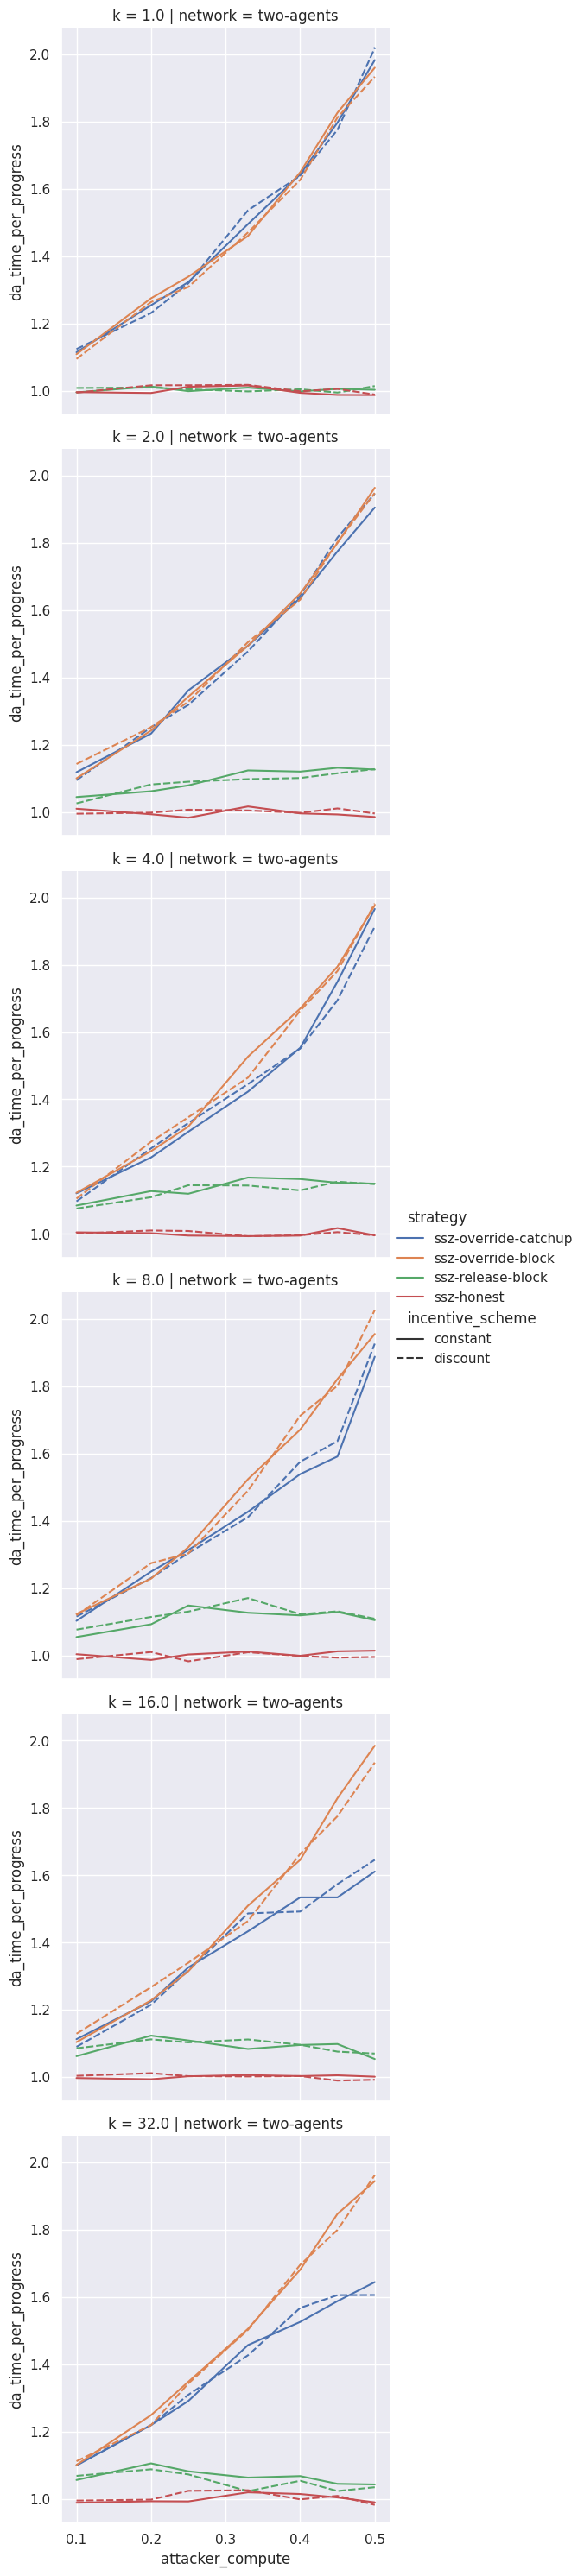

In [3]:
ax = sns.relplot(
    data=d.query('attack_space == "ssz" and protocol == "tailstormll"'),
    x="attacker_compute",
    y="da_time_per_progress",
    col="network",
    row="k",
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)

Check if orphans align across discount schemes (Tailstorm)

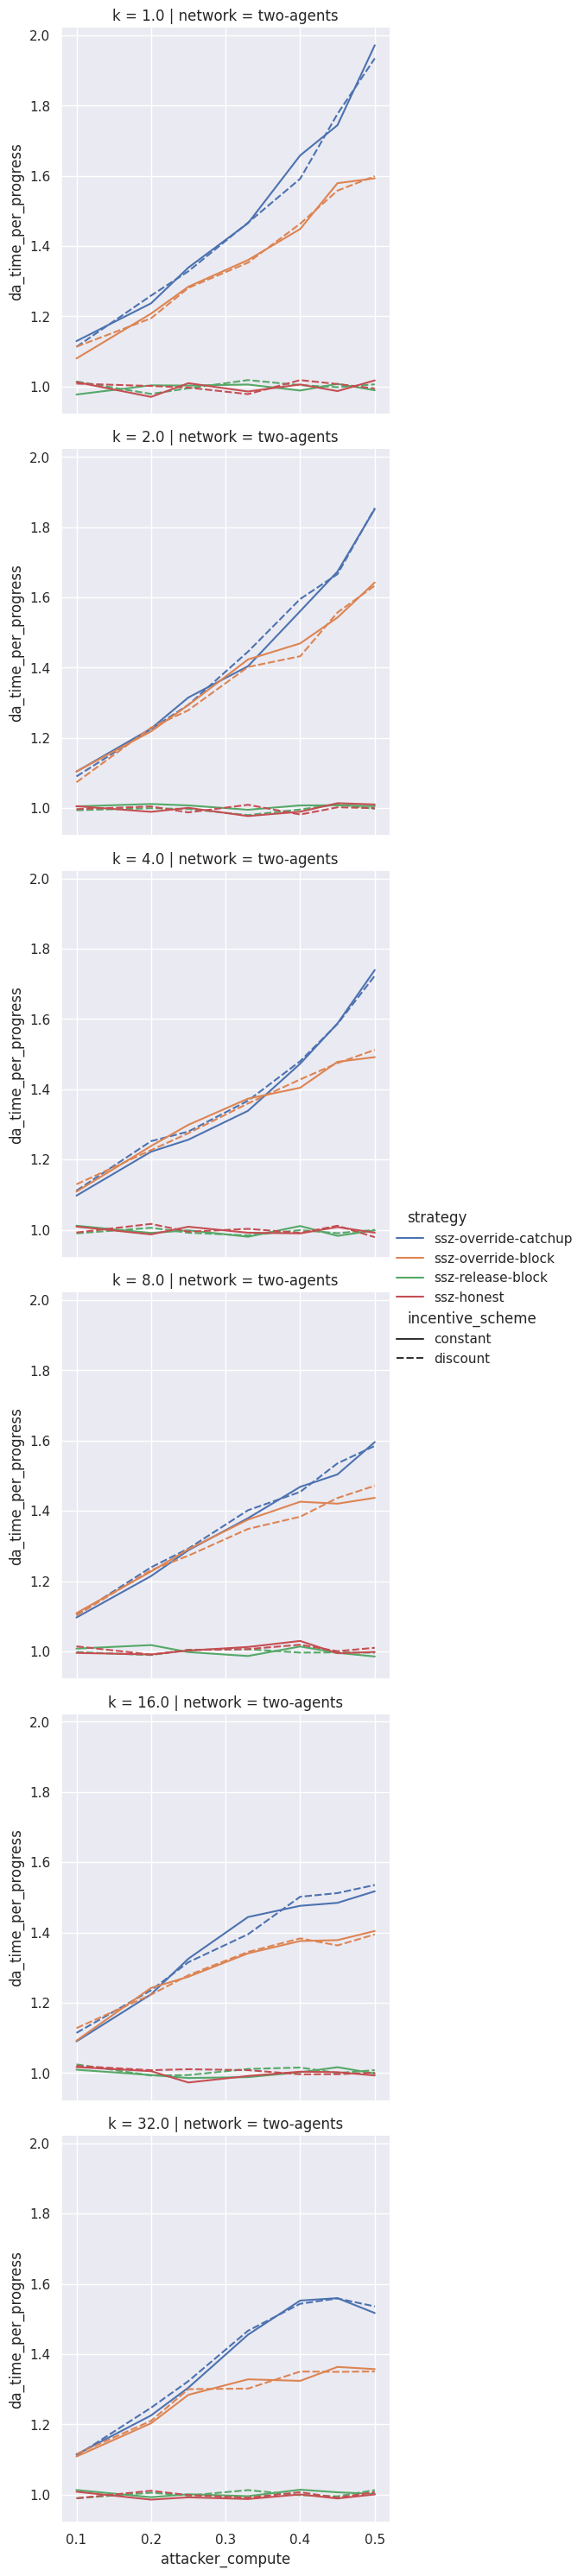

In [4]:
ax = sns.relplot(
    data=d.query('attack_space == "ssz" and protocol == "tailstorm"'),
    x="attacker_compute",
    y="da_time_per_progress",
    col="network",
    row="k",
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)

There seems to be no difference between the incenctive schemes. This is good.

Check difference between protocol implementations.

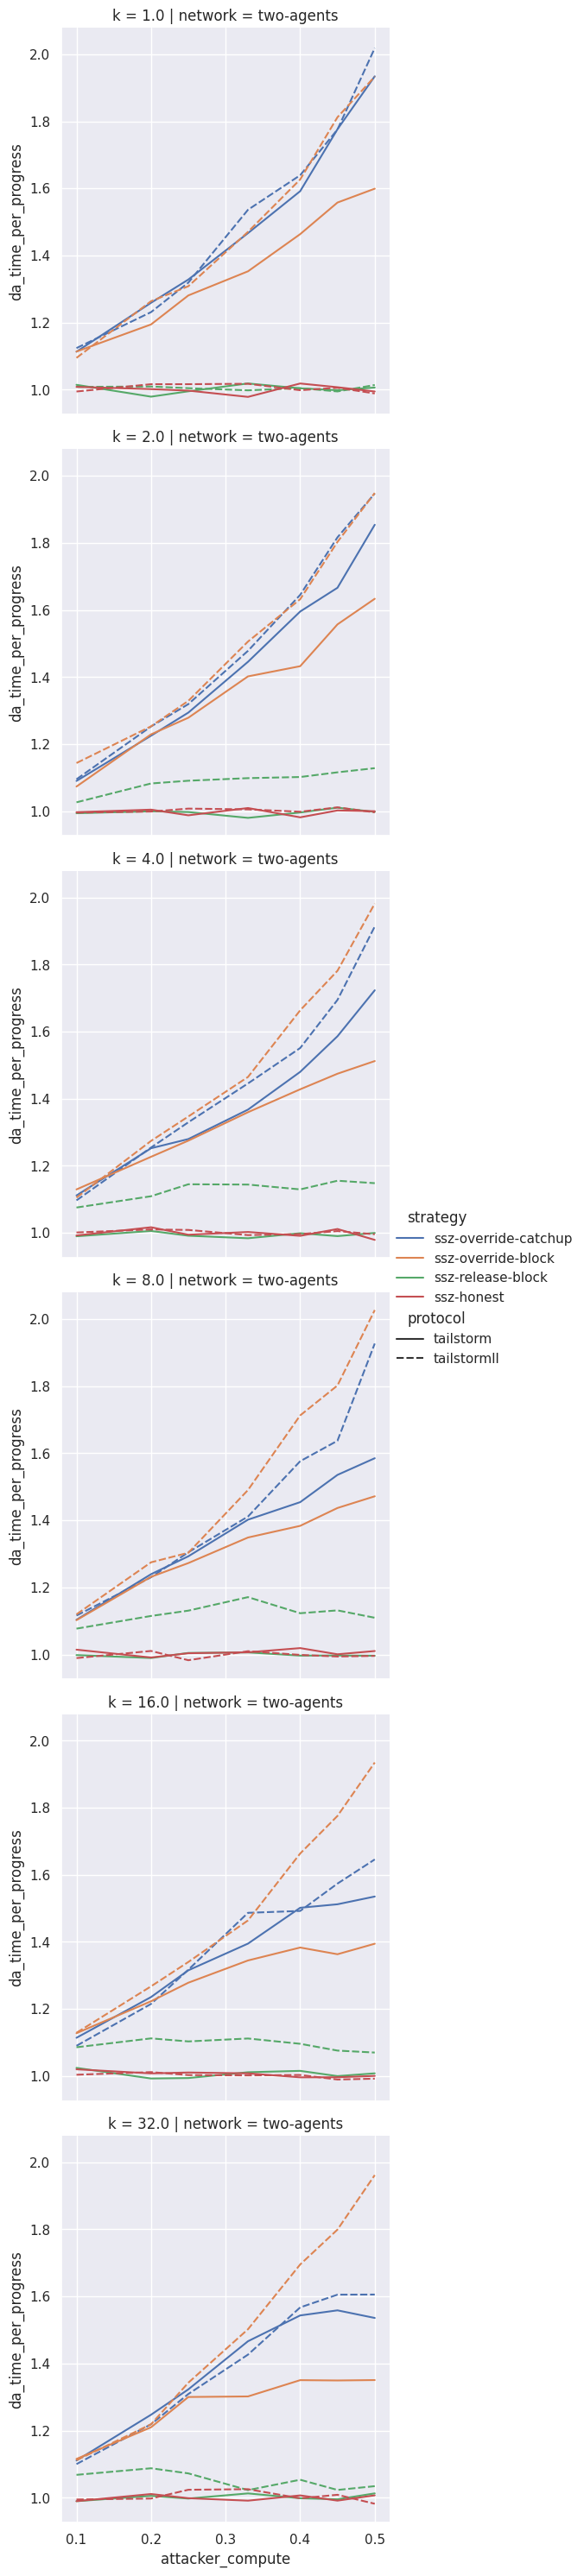

In [5]:
ax = sns.relplot(
    data=d.query('attack_space == "ssz" and incentive_scheme == "discount"'),
    x="attacker_compute",
    y="da_time_per_progress",
    col="network",
    row="k",
    hue="strategy",
    style="protocol",
    kind="line",
)

Let's have a look whether there are long forks

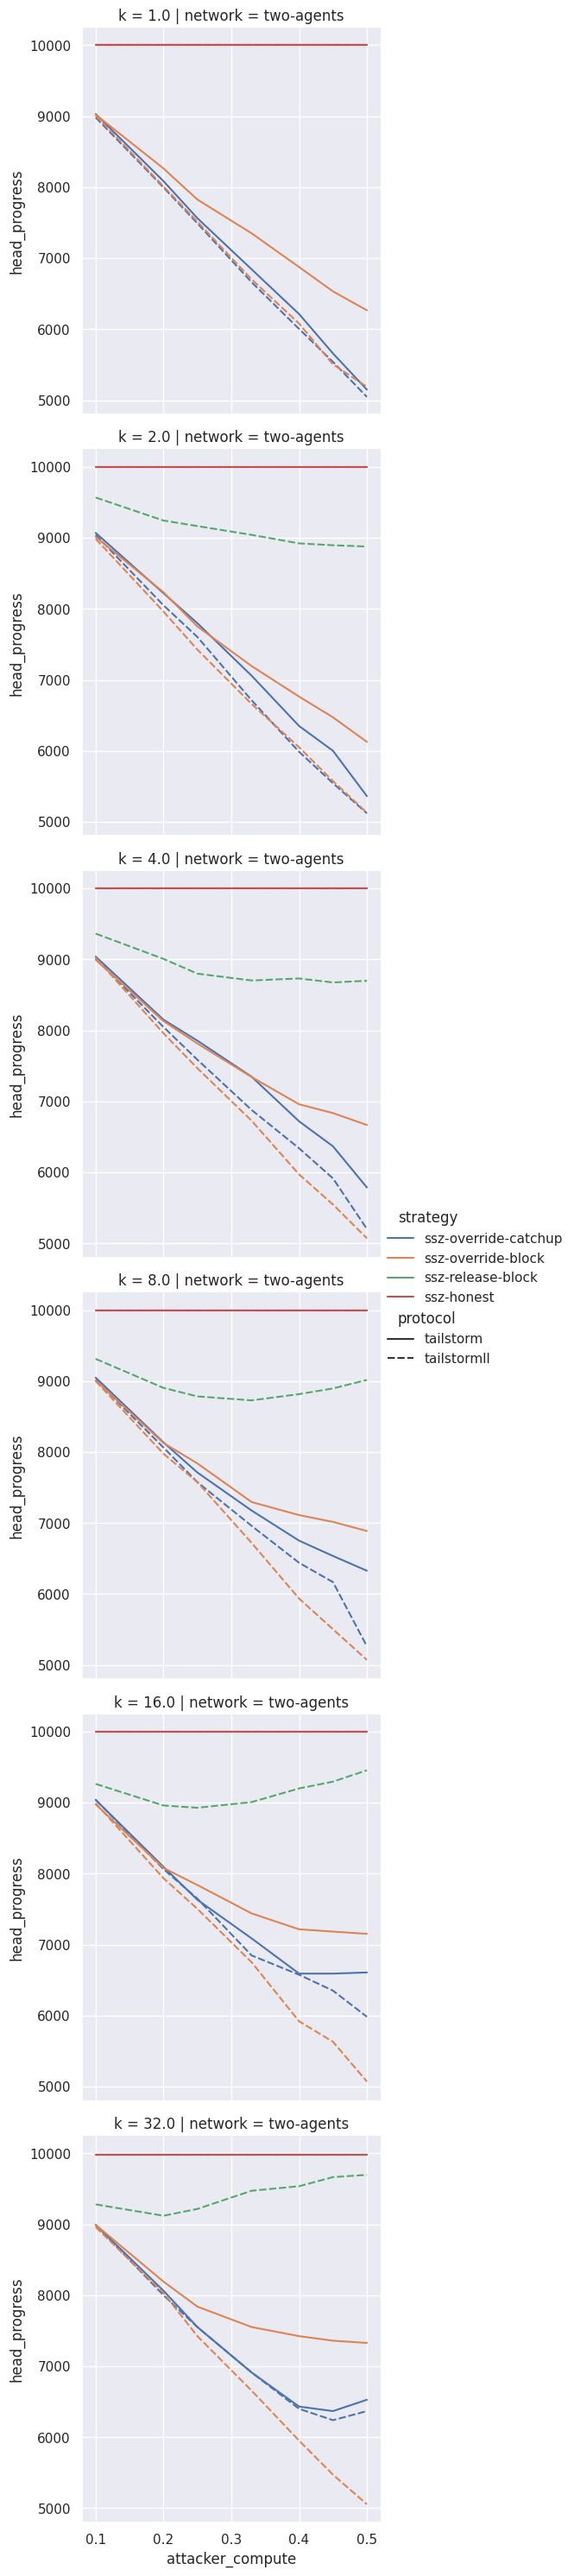

In [6]:
ax = sns.relplot(
    data=d.query('attack_space == "ssz" and incentive_scheme == "discount"'),
    x="attacker_compute",
    y="head_progress",
    row="k",
    col="network",
    hue="strategy",
    style="protocol",
    kind="line",
)

The differences are plausible. I guess that some attack strategies make less sense for one protocol implementation or the other.

Let's compare rewards across protocol implementation. It should be the same, otherwise there is a bug in the new protocol implementation, its attack space, or policies.

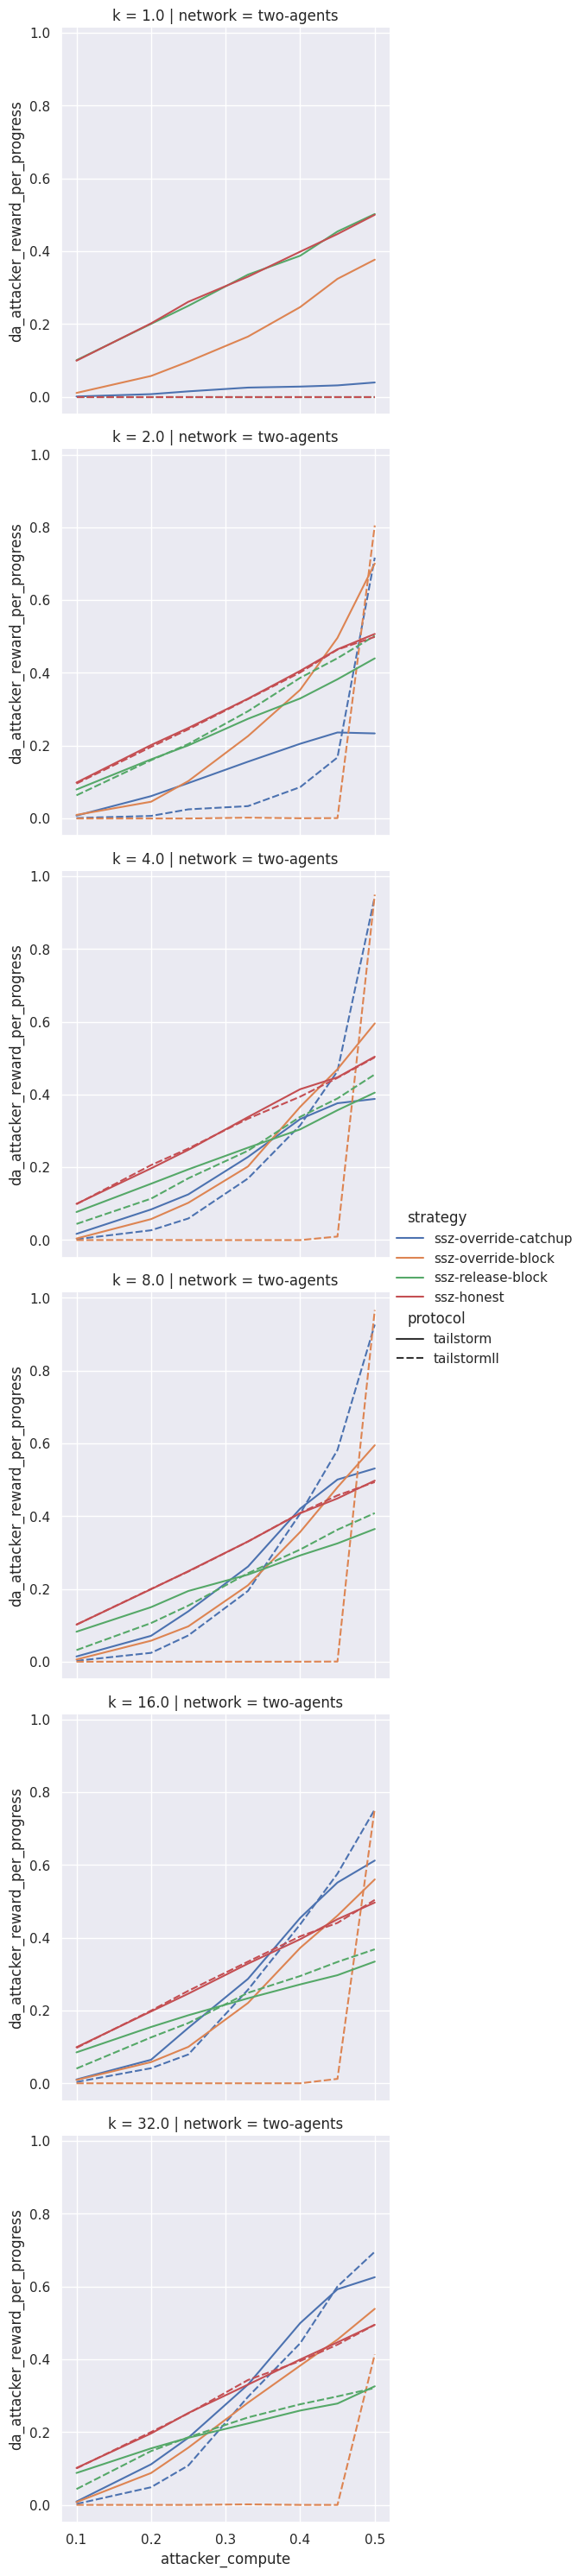

In [7]:
ax = sns.relplot(
    data=d.query('attack_space == "ssz" and incentive_scheme == "discount"'),
    x="attacker_compute",
    y="da_attacker_reward_per_progress",
    row="k",
    col="network",
    hue="strategy",
    style="protocol",
    kind="line",
)

Things look good. I guess the remaining issues are due to the policies beeing optimized for one protocol only.

---

I'm producing some figures here for a report somewhere in the git repo. At some point it should be revised though.

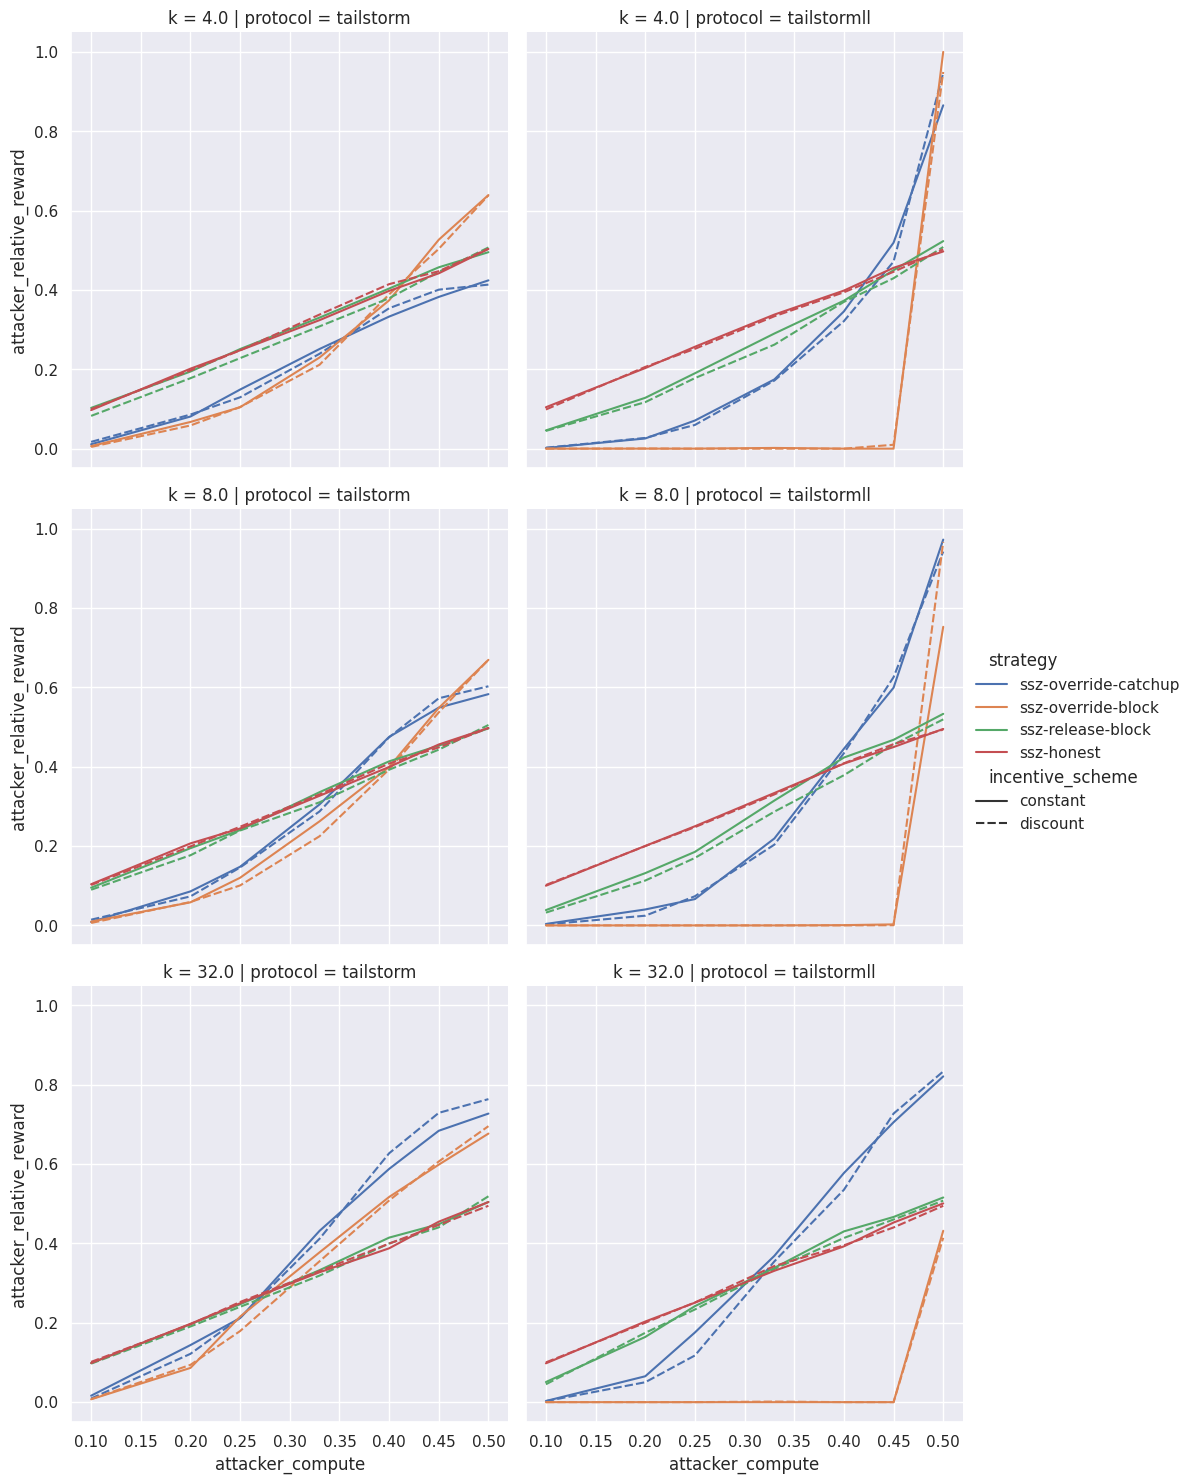

In [8]:
ax = sns.relplot(
    data=d.query('network == "two-agents" and k in [4, 8, 32]'),
    x="attacker_compute",
    y="attacker_relative_reward",
    row="k",
    col="protocol",
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_relative.png")

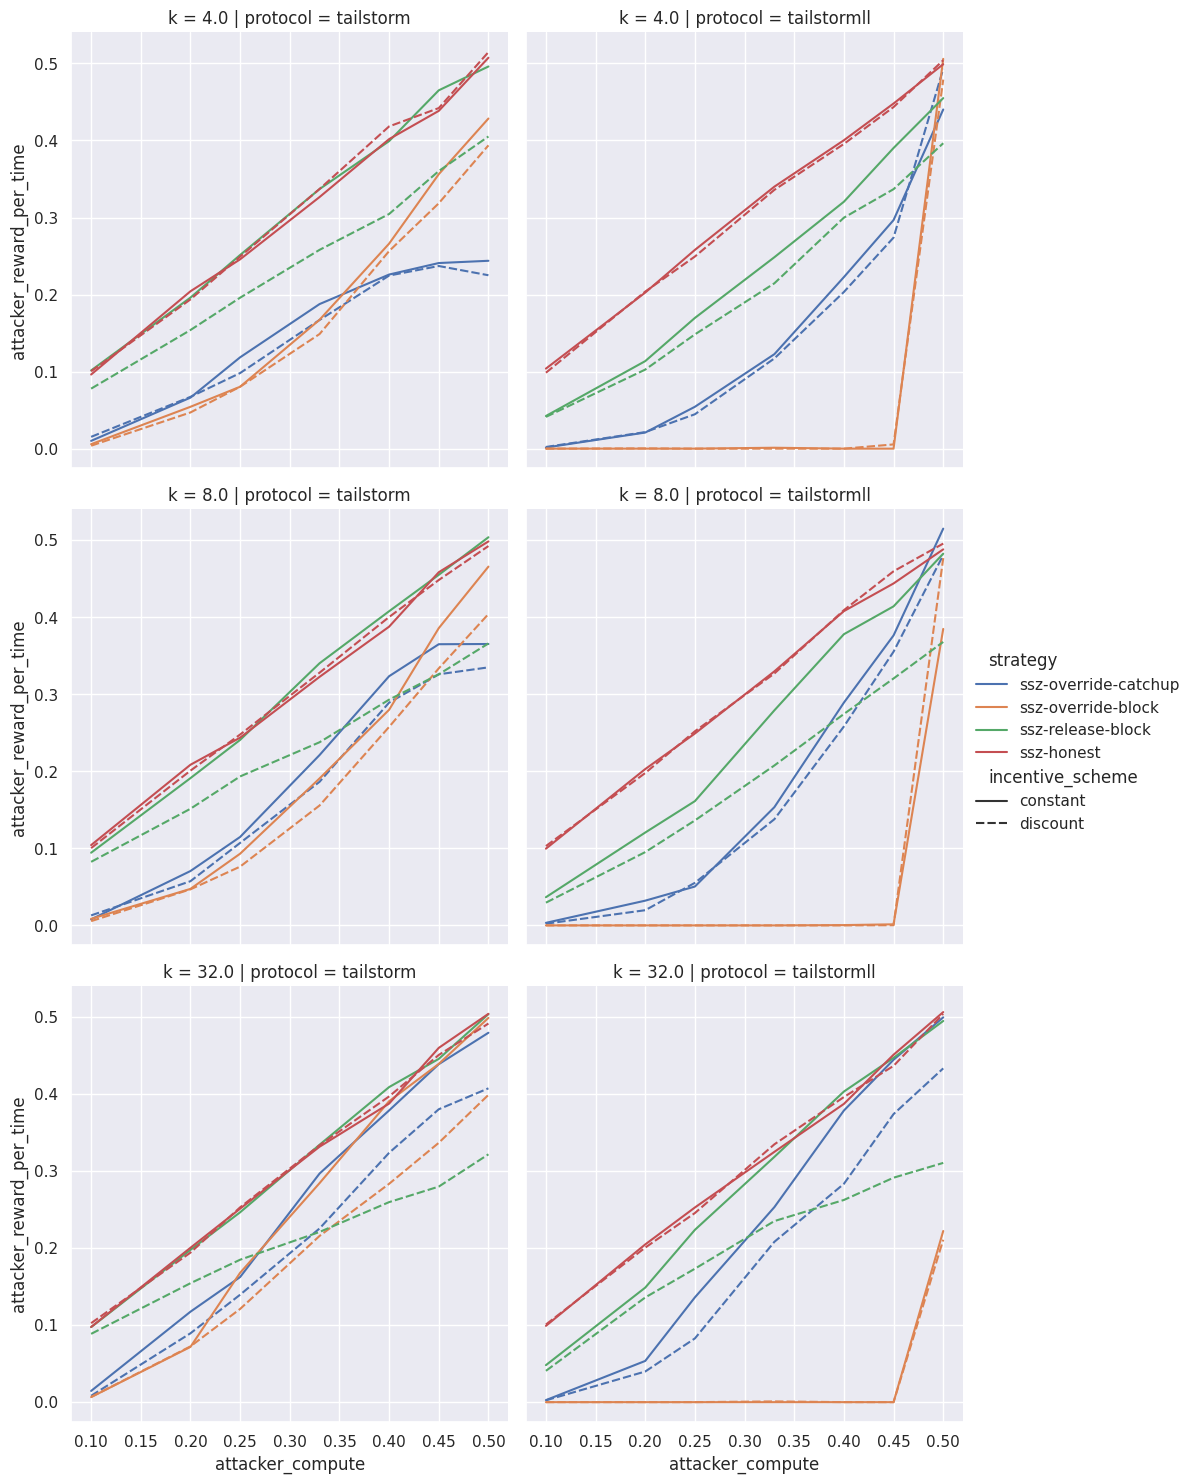

In [9]:
ax = sns.relplot(
    data=d.query('network == "two-agents" and k in [4, 8, 32]'),
    x="attacker_compute",
    y="attacker_reward_per_time",
    row="k",
    col="protocol",
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_absolute.png")

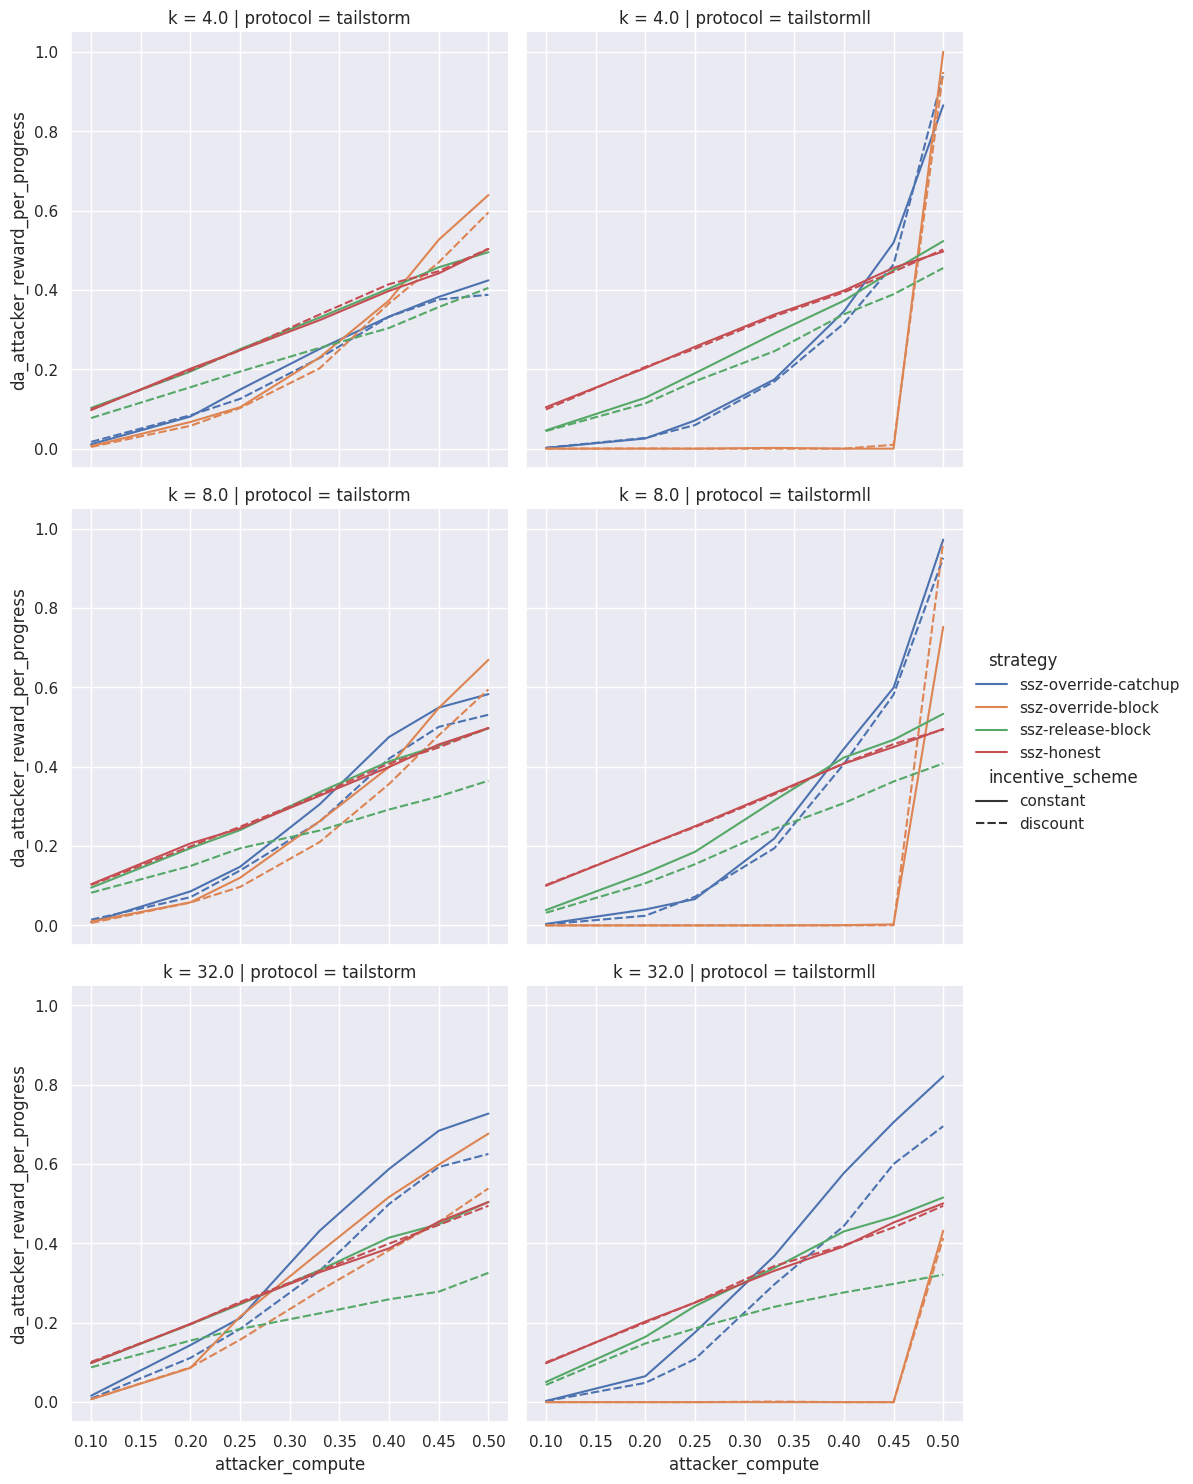

In [10]:
ax = sns.relplot(
    data=d.query('network == "two-agents" and k in [4, 8, 32]'),
    x="attacker_compute",
    y="da_attacker_reward_per_progress",
    row="k",
    col="protocol",
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_daa.png")

Comparision of attack spaces for Tailstorm/ll with emulated difficulty adjustment. This suggests that the ssz attack space is more powerfull than the old draft attack space. It also seems, that discount has an effect.